In [71]:
import numpy as np
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer

from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split

nltk.download('stopwords')
nltk.download('wordnet')
import re
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/habkaffee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/habkaffee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Preprocessing

Мы выбрали датасет с отзывами на Spotify за 2021-2022 года. 

Выполним стандартную подготовку датасета, уберем все не ASCII символы, пунктуацию и тд.

In [72]:
exclude_symbols = u''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є', '‹',
                            '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—', '‘', 
                            '\x7f', '\xad', '¤', '\xa0', '\u200b', '–']) + string.punctuation
regex_symb = re.compile('[%s]' % re.escape(exclude_symbols))

In [73]:
stop_words = stopwords.words('english')
pattern = r'\b(?:' + '|'.join(stop_words) + r')\b'
stop_words[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [74]:
tokenizer = WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()

In [75]:
dataset = pd.read_csv('data/DATASET.csv')

Имеем дизбаланс классов в сторону негативных отзывов, но решили его не устранять

In [76]:
dataset.shape

(52702, 2)

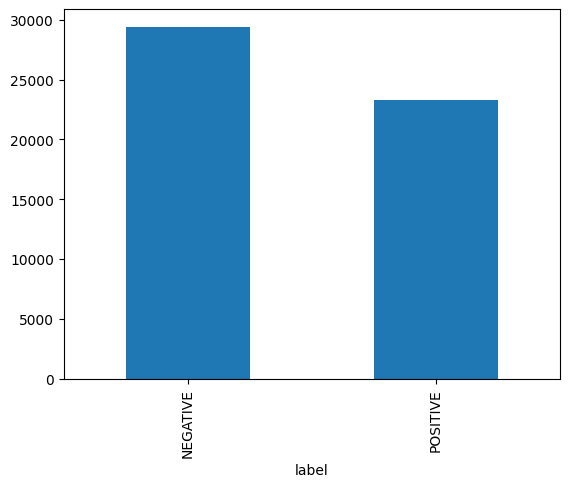

In [77]:
plt.figure()
dataset['label'].value_counts().plot.bar()
plt.show()

В ходе работы с датасетом пришло понимание, что мы работает с данными полученными от случайных людей, а значит там могут быть опечатки (Zpotify вместо Spotify), сленговые выражение (doooooing), сокращения (Ill вместо I will) и тд. Изначально без приведения подобных слов (с опечатками) к стандартному виду мы имели 15402 слов после препроцессинга. 
<!-- Добавив дополнительные слои отчистки теста от опечатов мы получили  -->

In [78]:
dataset['Review'] = dataset['Review'].str.lower()
dataset = dataset.loc[dataset['Review'].apply(lambda x: isinstance(x, str) and x.isascii())]
dataset['label'] = dataset['label'].str.replace('POSITIVE', '1').replace('NEGATIVE', '0')
dataset['Review'] = dataset['Review'].str.replace(pattern, '', regex=True)
dataset['Review'] = dataset['Review'].str.replace(f'[{string.punctuation}]+', ' ', regex=True)
dataset['Review'] = dataset['Review'].str.replace(r'\s+', ' ', regex=True)
dataset['Review'] = dataset['Review'].str.replace(f'[0-9]+', '', regex=True)

dataset['Review'] = dataset['Review'].apply(lambda sentence : tokenizer.tokenize(sentence))
dataset['Review'] = dataset['Review'].apply(lambda sentence : [lemmatizer.lemmatize(word, pos='n') for word in sentence])
dataset['Review'] = dataset['Review'].apply(lambda sentence : [lemmatizer.lemmatize(word, pos='v') for word in sentence])
dataset['Review'] = dataset['Review'].apply(lambda sentence : [lemmatizer.lemmatize(word, pos='a') for word in sentence])
dataset['Review'] = dataset['Review'].apply(lambda sentence : [lemmatizer.lemmatize(word, pos='r') for word in sentence])

dataset

,Review,label
0,"[great, music, service, audio, high, quality, ...",1
1,"[please, ignore, previous, negative, rat, app,...",1
2,"[pop, get, best, spotify, experience, android,...",0
3,"[really, buggy, terrible, use, recently]",0
4,"[dear, spotify, get, song, put, playlist, shuf...",0
...,...,...
52697,"[yes, best]",1
52698,"[spotify, heart, feb, heart, music, lyric, lan...",1
52699,"[try, open, app, wont, open, restart, phone, i...",1
52700,[good],1


Еще интересная особенность отзывов в том, что чем меньше тебе понравилось, тем больше отзыв ты напишешь. Так мы имеем большой список слов в "негативных" отзывах и "good" в "позитивыных". Своего рода это тоже может привести к дизбалансу, но это мы также решили не устранять

После препроцессинга датасет уменьшился примерно на 4000 отзывов. На дизбаланс классов это не повлияло.

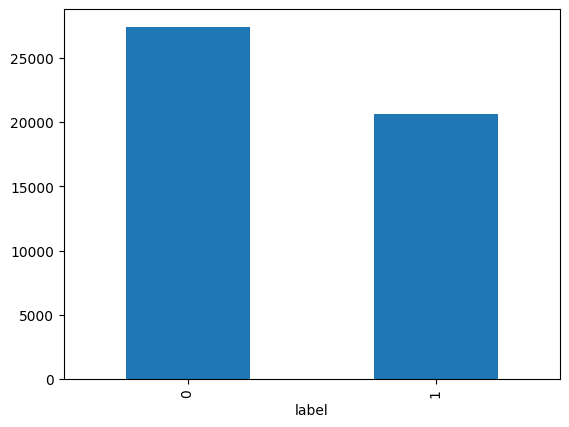

In [79]:
plt.figure()
dataset['label'].value_counts().plot.bar()
plt.show()

In [80]:
negative_df = dataset[dataset['label'] == '0']['Review'].apply(lambda x : ' '.join(x))
positive_df = dataset[dataset['label'] == '1']['Review'].apply(lambda x : ' '.join(x))

In [81]:
neg_res = negative_df.str.split(expand=True).stack().value_counts()
neg_res

song          17863
app           17285
play          13951
music          9206
spotify        8236
              ...  
wats              1
doooing           1
ingredient        1
margarita         1
unabled           1
Name: count, Length: 11726, dtype: int64

In [82]:
pos_res = positive_df.str.split(expand=True).stack().value_counts()
pos_res

music         10125
app            9199
song           6018
spotify        5287
love           5097
              ...  
connexion         1
anxious           1
horrendous        1
manualy           1
iykyk             1
Name: count, Length: 8406, dtype: int64

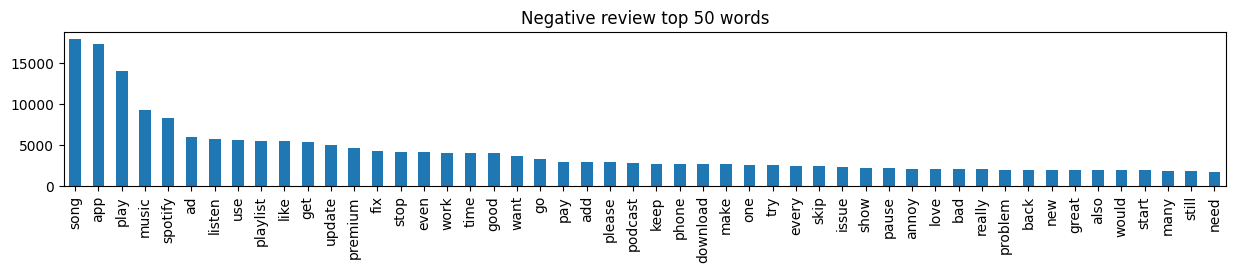

In [83]:
plt.figure(figsize=(15, 2))
neg_res[:50].plot.bar()
plt.title('Negative review top 50 words')
plt.show()

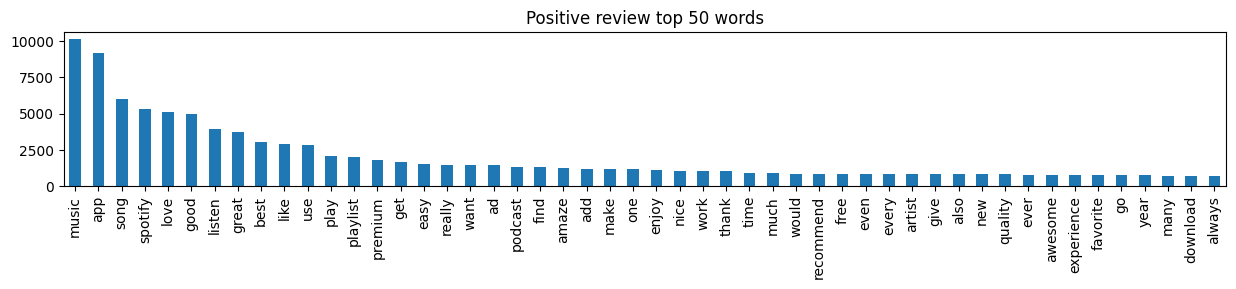

In [84]:
plt.figure(figsize=(15, 2))
pos_res[:50].plot.bar()
plt.title('Positive review top 50 words')
plt.show()

In [85]:
pos_res.sum(), neg_res.sum(), neg_res.sum() / pos_res.sum()

(198868, 492746, 2.477754088138866)

В обоих классах большое количество пересекающихся слов. Также в подтверждении тезиса, что в негативные отзывы больше - негативные отзывы содержат почти в 2.5 раза больше слов суммарно.

In [86]:
X, Y = dataset['Review'], dataset['label']

In [87]:
X.head()

0    [great, music, service, audio, high, quality, ...
1    [please, ignore, previous, negative, rat, app,...
2    [pop, get, best, spotify, experience, android,...
3             [really, buggy, terrible, use, recently]
4    [dear, spotify, get, song, put, playlist, shuf...
Name: Review, dtype: object

In [88]:
Y.head()

0    1
1    1
2    0
3    0
4    0
Name: label, dtype: object

In [89]:
all_words = set()
for data in X:
    all_words.update(data)
pd.DataFrame(all_words).T

,0,1,2,3,4,5,6,7,8,9,...,15392,15393,15394,15395,15396,15397,15398,15399,15400,15401
0,horsepower,cor,undesirable,complimentary,naaa,easypaisa,gife,importance,jerk,prize,...,execution,musicentertainment,uselessness,impassable,pausan,wabt,sindhi,batman,noodle,sticky


In [90]:
len(all_words)

15402

In [91]:
vectorizer = Word2Vec(X, vector_size=100, workers=4, min_count=3)
seed = 42

In [92]:
vectorizer.wv['app']

array([ 0.11588944, -0.18609694,  0.2016416 ,  0.7823311 , -0.7093305 ,
       -0.51250994, -0.6242197 ,  0.6694793 , -0.91398287,  0.03256154,
        0.35897943,  0.1942929 ,  0.00942864,  1.1696485 ,  0.00527045,
       -0.58337504, -0.5254196 , -0.34758466, -0.23038284,  0.44709697,
        1.0719485 , -0.02260556,  0.09740704, -0.14583626,  0.77888966,
        0.1293996 ,  0.34084427, -0.22839189, -0.89717996,  0.3237964 ,
       -0.19465601, -0.8371674 ,  0.3961469 , -0.9816299 ,  0.37670064,
        1.0863626 ,  0.03088634, -0.3162965 ,  0.45515424, -0.6616885 ,
       -1.1662586 ,  0.46321926, -0.08710835, -0.06712861,  0.86017233,
       -0.26414278,  0.13405436,  0.09949288,  1.547494  , -0.61838996,
        0.6140383 ,  0.59107214, -0.03087211, -0.17705809,  2.3088973 ,
       -0.10289801,  0.5544085 , -0.22790809,  0.5086942 , -0.17031954,
        0.18959148,  0.40844578, -0.05699442, -0.69828284, -0.2504678 ,
        0.10900823,  0.26821086,  1.2067888 ,  0.13472211, -0.98

In [93]:
def sentence_to_vector(sentence, model, vector_size):
    words = [word for word in sentence if word in model.wv]
    if not words:
        return np.zeros(vector_size)
    return np.mean([model.wv[word] for word in words], axis=0)

X_vectors = np.array([sentence_to_vector(sentence, vectorizer, 100) for sentence in X])

In [94]:
X_train, X_test, Y_train, Y_test = train_test_split(X_vectors, Y.astype(np.int8), test_size=0.25, random_state=seed)

# ML algs

Модели...набор классический:
  * LogisticRegression
  * LinearSVC

Оценивали по нескольким метрикам: pressision, accuracy, recall. Большее внимание уделяли accuracy, тк в нашем случае не важно соотношение ошибок первого и второго рода.

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Для перебора гиперпараметров использовали GridSearch, refit делали по f1_micro (тоже самое что и accuracy в случае бинарной классификации).

In [40]:
def get_gridsearch_for_model(model, parameters : dict) -> GridSearchCV:
    model_grid = GridSearchCV(
        estimator=model,
        param_grid=parameters,
        scoring=['f1_micro', 'accuracy', 'recall_macro'],
        refit='f1_micro',
        cv=5,
        verbose=2,
        error_score=0,
        n_jobs=8
    )
    return model_grid

def print_grid_search_info(model):
    print(f'Best estimator -> {model.best_estimator_}\n\
Best Score -> {model.best_score_}\n\
Best Parameters -> {model.best_params_}\n\
Best index -> {model.best_index_}')


def print_metrics(y_test, y_pred):
    print(f'accuracy_score = {accuracy_score(y_test, y_pred)}\nf1_micro = {f1_score(y_test, y_pred, average="micro")}\nrecall_score = {recall_score(y_test, y_pred, average="macro")}\nprecision_score = {precision_score(y_test, y_pred, average="macro")}')


def display_conf_matrix(y_true, y_pred, Y):
    conf_matrix = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(conf_matrix, display_labels=Y.unique())
    cm_display.plot()
    plt.show()

In [41]:
parameters_logreg = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 0.5, 1.0, 10.0],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [100, 500, 1000]
}

grid_log = get_gridsearch_for_model(LogisticRegression(), parameters_logreg)

grid_log.fit(X_train, Y_train)
print_grid_search_info(grid_log)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END .C=0.01, max_iter=100, penalty=l1, sol

/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ......C=1.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END ......C=1.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END .C=0.5, max_iter=1000, penalty=l1, solver=liblinear; total time=  10.3s
[CV] END .C=0.5, max_iter=1000, penalty=l1, solver=liblinear; total time=  10.5s
[CV] END ......C=1.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.5s
[CV] END ......C=1.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END ......C=1.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.5s


/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..C=1.0, max_iter=100, penalty=l2, solver=liblinear; total time=   2.5s
[CV] END ..C=1.0, max_iter=100, penalty=l2, solver=liblinear; total time=   2.5s
[CV] END ..C=1.0, max_iter=100, penalty=l2, solver=liblinear; total time=   2.6s
[CV] END ......C=1.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ......C=1.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ......C=1.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ......C=1.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ......C=1.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ..C=1.0, max_iter=100, penalty=l2, solver=liblinear; total time=   2.4s
[CV] END ..C=1.0, max_iter=100, penalty=l2, solver=liblinear; total time=   2.4s
[CV] END ..C=1.0, max_iter=100, penalty=l1, solver=liblinear; total time=  18.5s
[CV] END ..C=1.0, max_iter=100, penalty=l1, solver=liblinear; total time=  18.0s
[CV] END ..C=1.0, max_iter=1

/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....C=10.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END .C=1.0, max_iter=1000, penalty=l1, solver=liblinear; total time=  18.4s
[CV] END .....C=10.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.4s


/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV] END .....C=10.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END .....C=10.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.5s


/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....C=10.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END .C=1.0, max_iter=1000, penalty=l1, solver=liblinear; total time=  19.9s
[CV] END .C=10.0, max_iter=100, penalty=l2, solver=liblinear; total time=   4.0s
[CV] END .C=10.0, max_iter=100, penalty=l2, solver=liblinear; total time=   4.4s
[CV] END .C=10.0, max_iter=100, penalty=l2, solver=liblinear; total time=   4.8s
[CV] END .....C=10.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=10.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=10.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=10.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=10.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .C=10.0, max_iter=100, penalty=l2, solver=liblinear; total time=   4.7s
[CV] END .C=10.0, max_iter=100, penalty=l2, solver=liblinear; total time=   5.3s
[CV] END .C=10.0, max_iter=1

/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
75 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/vokanev/projects/nlp/nlp_classification/venv/

Best estimator -> LogisticRegression(C=10.0, max_iter=500)
Best Score -> 0.8612760055478501
Best Parameters -> {'C': 10.0, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
Best index -> 54


Лучшие параметры для логистической регрессии (на момент написания комментариев):
  * Лучший результат 0.860887656033287
  * Параметры: {'C': 10.0, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
    

In [42]:
Y_pred_logreg = grid_log.predict(X_test)
print_metrics(Y_test, Y_pred_logreg)
# save_model('./models/log_reg_trash.pkl', grid_log)

accuracy_score = 0.8586169593076475
f1_micro = 0.8586169593076475
recall_score = 0.8518228307326019
precision_score = 0.8583564091894211


In [43]:
parameters_linSVC = {
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'C': np.linspace(0.001, 0.1, 7),
    'max_iter': [1000, 3000, 5000],
    'dual':[True]
}

grid_linearSVC = get_gridsearch_for_model(LinearSVC(), parameters_linSVC)

grid_linearSVC.fit(X_train, Y_train)
print_grid_search_info(grid_linearSVC)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV] END C=0.001, dual=True, loss=hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=1000, penalty=l2; 

/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0175, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.0175, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.0175, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.001, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   0.2s
[CV] END C=0.0175, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END C=0.0175, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s
[CV] END C=0.0175, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.3s
[CV] END C=0.0175, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.2s
[CV] END C=0.0175, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.4s
[CV] END C=0.001, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   0.2s
[CV] END C=0.0175, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=  

/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0175, dual=True, loss=squared_hinge, max_iter=3000, penalty=l2; total time=   0.6s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.3s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0175, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   0.6s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END C=0.0175, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   0.6s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.034

/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.034, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.034, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.034, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.034, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.3s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.2s
[CV] END C=0.0175, dual=True, loss=squared_hinge, max_iter=1000, penalty=l2; total time=   0.6s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.3s
[CV] END C=0.0175, dual=True, loss=squared_hinge, max_iter=3000, penalty=l2; total time=   0.6s
[CV] END C=0.0175, dual=True, loss=squared_hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.0175, dual=True, loss=squared_hinge, max_iter=5000, penalty=l1; to

/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0505, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.1s
[CV] END C=0.0175, dual=True, loss=squared_hinge, max_iter=1000, penalty=l2; total time=   0.6s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END C=0.034, dual=True, loss=squared_hinge, max_iter=3000, penalty=l2; total time=   0.9s


/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.034, dual=True, loss=squared_hinge, max_iter=3000, penalty=l2; total time=   1.0s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END C=0.0175, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   0.6s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.0505

/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.034, dual=True, loss=squared_hinge, max_iter=3000, penalty=l2; total time=   0.9s
[CV] END C=0.034, dual=True, loss=squared_hinge, max_iter=3000, penalty=l2; total time=   0.9s
[CV] END C=0.034, dual=True, loss=squared_hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.034, dual=True, loss=squared_hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.4s
[CV] END C=0.0505, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.0505, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.0505, dual=True, loss=squared_hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.3s
[CV] END C=0.0505, dual=True, loss=squared_hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0505, dual=True, loss=squared_hinge, max_iter=3

/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0505, dual=True, loss=squared_hinge, max_iter=1000, penalty=l2; total time=   1.3s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END C=0.0505, dual=True, loss=squared_hinge, max_iter=3000, penalty=l2; total time=   1.3s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END C=0.034, dual=True, loss=squared_hinge, max_iter=1000, penalty=l2; total time=   0.9s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END C=0.0505, dual=True, loss=squared_hinge, max_iter=3000, penalty=l2; total time=   1.3s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s


/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.067, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s


/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0505, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   1.3s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.3s
[CV] END C=0.034, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   0.9s
[CV] END C=0.067, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[C

/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.067, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.3s
[CV] END C=0.0505, dual=True, loss=squared_hinge, max_iter=1000, penalty=l2; total time=   1.3s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.4s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.4s
[CV] END C=0.067, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.0505, dual=True, loss=squared_hinge, max_iter=3000, penalty=l2; total time=   1.4s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.6s
[CV] END C=0.0505, dual=True, loss=squared_hinge, max_iter=3000, penalty=l2; total time=   1.3s
[CV] END C=0.0505, dual=True, loss=squared_hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.0505, dual=True, loss=squared_hinge, max_iter=5000, penalty=l1; t

/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0835, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s


/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0835, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END C=0.067, dual=True, loss=squared_hinge, max_iter=3000, penalty=l2; total time=   1.6s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   1.6s
[CV] END C=0.067, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   1.6s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s


/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.3s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.3s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.3s
[CV] END C=0.067, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   1.6s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.6s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.6s
[CV] END C=0.0835, dual=T

/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.1, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s


/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.1, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s


/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.1, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   1.9s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=3000, penalty=l2; total time=   2.0s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=3000, penalty=l2; total time=   2.0s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   2.0s
[CV] END C=0.1, dual=

/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.3s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.3s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.3s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.4s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.3s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.3s
[CV] END C=0.1, dual=True

/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
210 fits failed out of a total of 420.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
105 fits failed with the following error:
Traceback (most recent call last):
  File "/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/vokanev/projects/nlp/nlp_classification/ven

Best estimator -> LinearSVC(C=0.067, dual=True, loss='hinge')
Best Score -> 0.8609431345353675
Best Parameters -> {'C': 0.067, 'dual': True, 'loss': 'hinge', 'max_iter': 1000, 'penalty': 'l2'}
Best index -> 49


/home/vokanev/projects/nlp/nlp_classification/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Лучшие параметры для SinearSVC (на момент написания комментариев):
  * Лучший результат 0.859889042995839
  * Параметры: {'C': 0.1, 'dual': True, 'loss': 'squared_hinge', 'max_iter': 1000, 'penalty': 'l2'}
    

In [44]:
Y_pred_linSVC = grid_linearSVC.predict(X_test)
print_metrics(Y_test, Y_pred_linSVC)

accuracy_score = 0.8595323292002995
f1_micro = 0.8595323292002995
recall_score = 0.8522839074170685
precision_score = 0.8597919453865304


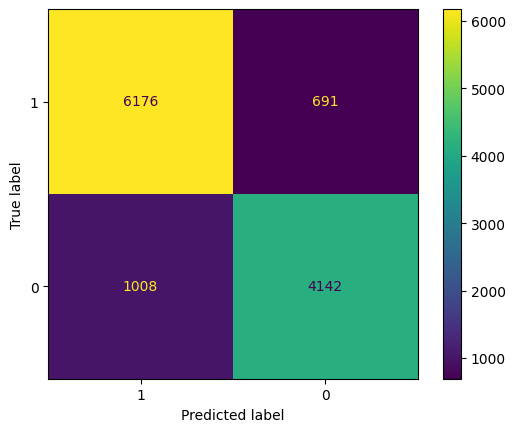

In [45]:
display_conf_matrix(Y_test, Y_pred_logreg, Y)

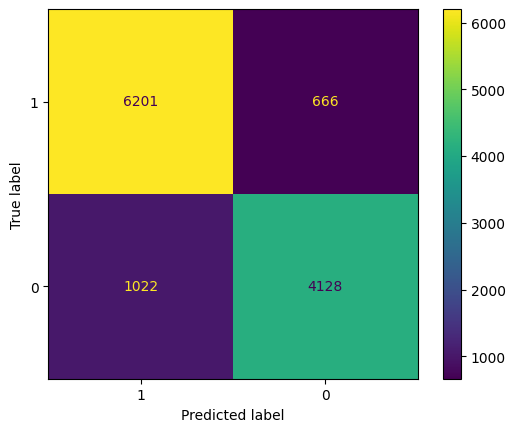

In [46]:
display_conf_matrix(Y_test, Y_pred_linSVC, Y)

И linear SVC, и logistic regression отрабатывают примерно одинаково и допускают много ошибок при классификации. Это связано с тем, что часто в негативных и позитивных отзывах используются схожие конструкции и слова. Также вероятно не моделям могло не хватать информации в отзывах, состоящих из малого количества слов. (как вариант можно попробовать убрать из рассмотрения короткие отзывы, но это сильно увеличит дизбаланс классов)

# NN Models

## Fully connected

Первая модель - простая полносвязанная нейронка: линейный слой $(100 \rightarrow 64)$, relu $ (64 \rightarrow 64)$, линейный слой $ (64 \rightarrow 1)$.

Для классификации использовали сигмоиду, поскольку задача - бинарная классификация. В другом случае нужно было бы использовать softmax.

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim

class FC_binary(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.Sigmoid()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.activation(out)
        return out

In [48]:
vector_size = 100
hidden_dim = 64
output_dim = 1
learning_rate = 0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Used device -> {device}')

fc_bin = FC_binary(vector_size, hidden_dim, output_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(fc_bin.parameters(), lr=learning_rate)

Used device -> cuda


In [49]:
X_train_nn = torch.tensor(X_train, dtype=torch.float32)
X_test_nn = torch.tensor(X_test, dtype=torch.float32)
Y_train_nn = torch.tensor(Y_train.to_numpy(), dtype=torch.float32)
Y_test_nn = torch.tensor(Y_test.to_numpy(), dtype=torch.float32)

In [50]:
fc_bin.to(device=device)

FC_binary(
  (fc1): Linear(in_features=100, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (activation): Sigmoid()
)

In [51]:
num_epochs = 100
batch_size = 32
train_data = torch.utils.data.TensorDataset(X_train_nn, Y_train_nn)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [52]:
for epoch in range(num_epochs):
    fc_bin.train()
    total_loss = 0
    for X_batch, Y_batch in train_loader:
        X_batch = X_batch.to(device=device)
        Y_batch = Y_batch.to(device=device)
        
        outputs = fc_bin(X_batch).squeeze(1)
        loss = criterion(outputs, Y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')


Epoch 1/100, Loss: 0.3589346690207535
Epoch 2/100, Loss: 0.3330564867001037
Epoch 3/100, Loss: 0.32595612184733763
Epoch 4/100, Loss: 0.3218830597207625
Epoch 5/100, Loss: 0.3181997410880324
Epoch 6/100, Loss: 0.3153109707751418
Epoch 7/100, Loss: 0.31281459961539365
Epoch 8/100, Loss: 0.31009771369443917
Epoch 9/100, Loss: 0.3084822272569496
Epoch 10/100, Loss: 0.3069671064866467
Epoch 11/100, Loss: 0.3060590571723052
Epoch 12/100, Loss: 0.3035457095638671
Epoch 13/100, Loss: 0.30241846714330756
Epoch 14/100, Loss: 0.30090716126198885
Epoch 15/100, Loss: 0.29985489476118454
Epoch 16/100, Loss: 0.2990913163298723
Epoch 17/100, Loss: 0.2971701821727148
Epoch 18/100, Loss: 0.29662501386894835
Epoch 19/100, Loss: 0.29589448304650207
Epoch 20/100, Loss: 0.294804047545238
Epoch 21/100, Loss: 0.2938308597483673
Epoch 22/100, Loss: 0.29315818916302183
Epoch 23/100, Loss: 0.2922878459677722
Epoch 24/100, Loss: 0.2918007075257712
Epoch 25/100, Loss: 0.290926137610199
Epoch 26/100, Loss: 0.28921

In [54]:
fc_bin.eval()
X_test_nn = X_test_nn.to(device=device)
Y_test_nn = Y_test_nn.to(device=device)
with torch.no_grad():
    outputs = fc_bin(X_test_nn).squeeze(1)
    predictions = (outputs > 0.5).float()
    accuracy = (predictions == Y_test_nn).float().mean()
    print(f'Test Accuracy: {accuracy:.8f}')
    
torch.save(fc_bin.state_dict(), f'./models/fc_test_{accuracy:.5f}.pth')

Test Accuracy: 0.85928273


Лучшая accuracy, полученная в ходе экспериментов, $\approx 0.87$ вне зависимости от числа эпох (смотрели на 50, 75, 100, 200, 300). 

## CNN Classifier

Следующия модель - сверточная нейронная сеть. 

Структура:
  * Одномерная свертка с ядром 3
  * Одномерная свертка с ядром 4
  * Одномерная свертка с ядром 5
  * MaxPolling
  * Конкатенация
  * DropOut $p=0.5$
  * Линейный слой $(3 \cdot 100) \rightarrow 1$
  

In [55]:
class CNNTextClassifier(nn.Module):
    def __init__(self, embedding_dim, num_filters, filter_sizes, output_dim, dropout=0.5):
        super().__init__()
        
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=fs) for fs in filter_sizes
        ])
        
        self.fc = nn.Linear(len(filter_sizes) * num_filters, output_dim)

        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x = x.unsqueeze(1)
        
        conved = [torch.relu(conv(x)) for conv in self.convs]
        pooled = [torch.max(c, dim=2)[0] for c in conved] # Max pooling over dims
        
        cat = torch.cat(pooled, dim=1)
        cat = self.dropout(cat)
        
        output = self.fc(cat)
        
        return torch.sigmoid(output).squeeze(1)



In [56]:
vector_size = 100
num_filters = 100
filter_sizes = [3, 4, 5]
output_dim = 1 
dropout = 0.5

In [57]:
CNN_bin = CNNTextClassifier(vector_size, num_filters, filter_sizes, output_dim, dropout)
criterion = nn.BCELoss()
optimizer = optim.Adam(CNN_bin.parameters(), lr=learning_rate)

In [58]:
CNN_bin.to(device=device)

CNNTextClassifier(
  (convs): ModuleList(
    (0): Conv1d(1, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(1, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(1, 100, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [59]:
num_epochs = 50
batch_size = 32
train_data = torch.utils.data.TensorDataset(X_train_nn, Y_train_nn)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    CNN_bin.train()
    total_loss = 0
    for X_batch, Y_batch in train_loader:
       
        X_batch = X_batch.to(device=device)
        Y_batch = Y_batch.to(device=device)
        outputs = CNN_bin(X_batch)
        loss = criterion(outputs, Y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}')

Epoch 1/50, Loss: 0.5912
Epoch 2/50, Loss: 0.5253
Epoch 3/50, Loss: 0.5061
Epoch 4/50, Loss: 0.4968
Epoch 5/50, Loss: 0.4922
Epoch 6/50, Loss: 0.4874
Epoch 7/50, Loss: 0.4867
Epoch 8/50, Loss: 0.4830
Epoch 9/50, Loss: 0.4831
Epoch 10/50, Loss: 0.4805
Epoch 11/50, Loss: 0.4784
Epoch 12/50, Loss: 0.4743
Epoch 13/50, Loss: 0.4775
Epoch 14/50, Loss: 0.4758
Epoch 15/50, Loss: 0.4730
Epoch 16/50, Loss: 0.4746
Epoch 17/50, Loss: 0.4691
Epoch 18/50, Loss: 0.4716
Epoch 19/50, Loss: 0.4714
Epoch 20/50, Loss: 0.4723
Epoch 21/50, Loss: 0.4697
Epoch 22/50, Loss: 0.4683
Epoch 23/50, Loss: 0.4725
Epoch 24/50, Loss: 0.4682
Epoch 25/50, Loss: 0.4666
Epoch 26/50, Loss: 0.4656
Epoch 27/50, Loss: 0.4672
Epoch 28/50, Loss: 0.4691
Epoch 29/50, Loss: 0.4694
Epoch 30/50, Loss: 0.4677
Epoch 31/50, Loss: 0.4669
Epoch 32/50, Loss: 0.4672
Epoch 33/50, Loss: 0.4674
Epoch 34/50, Loss: 0.4702
Epoch 35/50, Loss: 0.4672
Epoch 36/50, Loss: 0.4670
Epoch 37/50, Loss: 0.4674
Epoch 38/50, Loss: 0.4662
Epoch 39/50, Loss: 0.

In [60]:
CNN_bin.eval()
X_test_nn = X_test_nn.to(device=device)
Y_test_nn = Y_test_nn.to(device=device)

with torch.no_grad():
    outputs = CNN_bin(X_test_nn)
    predictions = (outputs > 0.5).float()
    accuracy = (predictions == Y_test_nn).float().mean()
    print(f'Test Accuracy: {accuracy:.6f}')
    
torch.save(fc_bin.state_dict(), f'./models/cnn_test_{accuracy:.6f}.pth')

Test Accuracy: 0.811850


CNN обучали на том же количестве эпох что и полносвязную модель. Лучшая точность за время экспериментов была $0.821753$

# Эксперименты

В рамках эксперимента мы попробуем заменить WhitespaceTokenizer токенайзер на TweetTokenizer. В теории он должен решить проблемы с наличием сленговых выражений. Мы также попытались избавится от опечаток через Textblob, но это было слишком затратно по времени

In [64]:
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer()

dataset = pd.read_csv('data/DATASET.csv')

dataset['Review'] = dataset['Review'].str.lower()
dataset = dataset.loc[dataset['Review'].apply(lambda x: isinstance(x, str) and x.isascii())]
dataset['label'] = dataset['label'].str.replace('POSITIVE', '1').replace('NEGATIVE', '0')
dataset['Review'] = dataset['Review'].str.replace(pattern, '', regex=True)
dataset['Review'] = dataset['Review'].str.replace(f'[{string.punctuation}]+', ' ', regex=True)
dataset['Review'] = dataset['Review'].str.replace(r'\s+', ' ', regex=True)

dataset['Review'] = dataset['Review'].apply(lambda sentence : tokenizer.tokenize(sentence))
dataset['Review'] = dataset['Review'].apply(lambda sentence : [lemmatizer.lemmatize(word, pos='n') for word in sentence])
dataset['Review'] = dataset['Review'].apply(lambda sentence : [lemmatizer.lemmatize(word, pos='v') for word in sentence])
dataset['Review'] = dataset['Review'].apply(lambda sentence : [lemmatizer.lemmatize(word, pos='a') for word in sentence])
dataset['Review'] = dataset['Review'].apply(lambda sentence : [lemmatizer.lemmatize(word, pos='r') for word in sentence])
# dataset['Review'] = dataset['Review'].apply(lambda sentence : ' '.join(sentence))
dataset

,Review,label
0,"[great, music, service, audio, high, quality, ...",1
1,"[please, ignore, previous, negative, rat, app,...",1
2,"[pop, get, best, spotify, experience, android,...",0
3,"[really, buggy, terrible, use, recently]",0
4,"[dear, spotify, get, song, put, playlist, shuf...",0
...,...,...
52697,"[yes, best]",1
52698,"[spotify, heart, feb, 2024, heart, music, lyri...",1
52699,"[try, open, app, wont, open, restart, phone, i...",1
52700,[good],1


In [66]:
vector_size = 100
hidden_dim = 64
output_dim = 1
learning_rate = 0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Used device -> {device}')

fc_bin = FC_binary(vector_size, hidden_dim, output_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(fc_bin.parameters(), lr=learning_rate)

X_train_nn = torch.tensor(X_train, dtype=torch.float32)
X_test_nn = torch.tensor(X_test, dtype=torch.float32)
Y_train_nn = torch.tensor(Y_train.to_numpy(), dtype=torch.float32)
Y_test_nn = torch.tensor(Y_test.to_numpy(), dtype=torch.float32)

fc_bin.to(device=device)

num_epochs = 100
batch_size = 32
train_data = torch.utils.data.TensorDataset(X_train_nn, Y_train_nn)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    fc_bin.train()
    total_loss = 0
    for X_batch, Y_batch in train_loader:
        X_batch = X_batch.to(device=device)
        Y_batch = Y_batch.to(device=device)
        
        outputs = fc_bin(X_batch).squeeze(1)
        loss = criterion(outputs, Y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')


fc_bin.eval()
X_test_nn = X_test_nn.to(device=device)
Y_test_nn = Y_test_nn.to(device=device)
with torch.no_grad():
    outputs = fc_bin(X_test_nn).squeeze(1)
    predictions = (outputs > 0.5).float()
    accuracy = (predictions == Y_test_nn).float().mean()
    print(f'Test Accuracy: {accuracy:.8f}')
    
torch.save(fc_bin.state_dict(), f'./models/fc_test_{accuracy:.5f}.pth')

Used device -> cuda
Epoch 1/100, Loss: 0.3604298342406062
Epoch 2/100, Loss: 0.33390497713752204
Epoch 3/100, Loss: 0.32568336753530003
Epoch 4/100, Loss: 0.3215165786319532
Epoch 5/100, Loss: 0.3179505047220621
Epoch 6/100, Loss: 0.3153654788129078
Epoch 7/100, Loss: 0.31238159684740346
Epoch 8/100, Loss: 0.310030157865416
Epoch 9/100, Loss: 0.3085647498347533
Epoch 10/100, Loss: 0.30711001051984854
Epoch 11/100, Loss: 0.3054183650011496
Epoch 12/100, Loss: 0.3037489978026371
Epoch 13/100, Loss: 0.3021785793388006
Epoch 14/100, Loss: 0.3005583847425845
Epoch 15/100, Loss: 0.30021200930665
Epoch 16/100, Loss: 0.2980855703155552
Epoch 17/100, Loss: 0.29805010030940243
Epoch 18/100, Loss: 0.29658495478774977
Epoch 19/100, Loss: 0.29640309880185994
Epoch 20/100, Loss: 0.29499751094732013
Epoch 21/100, Loss: 0.29328700924538464
Epoch 22/100, Loss: 0.2935785660164856
Epoch 23/100, Loss: 0.2921637569445895
Epoch 24/100, Loss: 0.29188985863457556
Epoch 25/100, Loss: 0.2910757348893381
Epoch 2

После замены токенайзера, accuracy в полносвязной нейронной сети изменилось на уровне погрешности. Возможно, кардинальных изменений не последовало, так как изначально был использован whitespace tokenizer (довольно универсальный) или в наборе данных не так много сленговых выражений, чтобы были кардинальные изменения.

In [108]:
tokenizer = WhitespaceTokenizer()

dataset = pd.read_csv('data/DATASET.csv')

dataset['Review'] = dataset['Review'].str.lower()
dataset = dataset.loc[dataset['Review'].apply(lambda x: isinstance(x, str) and x.isascii())]
dataset['label'] = dataset['label'].str.replace('POSITIVE', '1').replace('NEGATIVE', '0')
dataset['Review'] = dataset['Review'].str.replace(pattern, '', regex=True)
dataset['Review'] = dataset['Review'].str.replace(f'[{string.punctuation}]+', ' ', regex=True)
dataset['Review'] = dataset['Review'].str.replace(r'\s+', ' ', regex=True)

dataset['Review'] = dataset['Review'].apply(lambda sentence : tokenizer.tokenize(sentence))
dataset['Review'] = dataset['Review'].apply(lambda sentence : [lemmatizer.lemmatize(word, pos='n') for word in sentence])
dataset['Review'] = dataset['Review'].apply(lambda sentence : [lemmatizer.lemmatize(word, pos='v') for word in sentence])
dataset['Review'] = dataset['Review'].apply(lambda sentence : [lemmatizer.lemmatize(word, pos='a') for word in sentence])
dataset['Review'] = dataset['Review'].apply(lambda sentence : [lemmatizer.lemmatize(word, pos='r') for word in sentence])
dataset = dataset.loc[dataset['Review'].apply(lambda x : len(x) > 5)]
# dataset['Review'] = dataset['Review'].apply(lambda sentence : ' '.join(sentence))

In [116]:
negative_df = dataset[dataset['label'] == '0']
positive_df = dataset[dataset['label'] == '1']

In [117]:
negative_df = negative_df.sample(len(positive_df))

In [120]:
negative_df, positive_df

(                                                  Review label
 42486  [bad, performance, good, app, untill, recently...     0
 26922  [cant, download, playlist, download, episode, ...     0
 23928  [bunch, ad, song, buy, premium, let, play, wha...     0
 33373  [eat, 3gb, data, within, couple, minute, even,...     0
 31263  [app, keep, cut, show, playback, information, ...     0
 ...                                                  ...   ...
 19617  [collection, good, say, lyric, feature, though...     0
 15478  [good, app, idea, happen, 24th, update, app, s...     0
 7646   [lyric, go, new, update, thru, playstore, remove]     0
 35738  [recent, update, break, music, controlls, some...     0
 29472  [well, grade, review, app, start, pause, redow...     0
 
 [12871 rows x 2 columns],
                                                   Review label
 0      [great, music, service, audio, high, quality, ...     1
 1      [please, ignore, previous, negative, rat, app,...     1
 6        [

In [138]:
X = pd.concat([negative_df, positive_df])
X = X.sample(frac=1)
X, Y = X['Review'], X['label']

In [139]:
vectorizer = Word2Vec(X, vector_size=100, workers=4, min_count=3)
seed = 42

def sentence_to_vector(sentence, model, vector_size):
    words = [word for word in sentence if word in model.wv]
    if not words:
        return np.zeros(vector_size)
    return np.mean([model.wv[word] for word in words], axis=0)

X_vectors = np.array([sentence_to_vector(sentence, vectorizer, 100) for sentence in X])

X_train, X_test, Y_train, Y_test = train_test_split(X_vectors, Y.astype(np.int8), test_size=0.25, random_state=seed)

In [142]:
vector_size = 100
hidden_dim = 64
output_dim = 1
learning_rate = 0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Used device -> {device}')

fc_bin = FC_binary(vector_size, hidden_dim, output_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(fc_bin.parameters(), lr=learning_rate)

X_train_nn = torch.tensor(X_train, dtype=torch.float32)
X_test_nn = torch.tensor(X_test, dtype=torch.float32)
Y_train_nn = torch.tensor(Y_train.to_numpy(), dtype=torch.float32)
Y_test_nn = torch.tensor(Y_test.to_numpy(), dtype=torch.float32)

fc_bin.to(device=device)

num_epochs = 100
batch_size = 32
train_data = torch.utils.data.TensorDataset(X_train_nn, Y_train_nn)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    fc_bin.train()
    total_loss = 0
    for X_batch, Y_batch in train_loader:
        X_batch = X_batch.to(device=device)
        Y_batch = Y_batch.to(device=device)
        
        outputs = fc_bin(X_batch).squeeze(1)
        loss = criterion(outputs, Y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')


fc_bin.eval()
X_test_nn = X_test_nn.to(device=device)
Y_test_nn = Y_test_nn.to(device=device)
with torch.no_grad():
    outputs = fc_bin(X_test_nn).squeeze(1)
    predictions = (outputs > 0.5).float()
    accuracy = (predictions == Y_test_nn).float().mean()
    print(f'Test Accuracy: {accuracy:.8f}')
    
torch.save(fc_bin.state_dict(), f'./models/fc_test_{accuracy:.5f}.pth')

Used device -> cuda
Epoch 1/100, Loss: 0.42489012626820055
Epoch 2/100, Loss: 0.3978274193475183
Epoch 3/100, Loss: 0.39115017889351245
Epoch 4/100, Loss: 0.3878161768546168
Epoch 5/100, Loss: 0.38387633433306456
Epoch 6/100, Loss: 0.38229062356400173
Epoch 7/100, Loss: 0.3789165046880182
Epoch 8/100, Loss: 0.37606476227574
Epoch 9/100, Loss: 0.3746887286569898
Epoch 10/100, Loss: 0.37206471005812386
Epoch 11/100, Loss: 0.37124266142383316
Epoch 12/100, Loss: 0.3694217030871783
Epoch 13/100, Loss: 0.36937762259055446
Epoch 14/100, Loss: 0.36796035632392426
Epoch 15/100, Loss: 0.36629519791693876
Epoch 16/100, Loss: 0.36555585275027924
Epoch 17/100, Loss: 0.36506207209598546
Epoch 18/100, Loss: 0.36468074701430386
Epoch 19/100, Loss: 0.3637436818923579
Epoch 20/100, Loss: 0.3618093860267803
Epoch 21/100, Loss: 0.3616529560296346
Epoch 22/100, Loss: 0.3599372494793096
Epoch 23/100, Loss: 0.3606304914400672
Epoch 24/100, Loss: 0.35860316711940515
Epoch 25/100, Loss: 0.35951996246809204
Ep

Балансировка датасета повлекла за собой постоянное ухудшение качества на 2% при тренировке на [50, 75, 100, 200] эпохах. После 200 эпох качество начинает сильно падать. Скорее всего, на такое ухудшение качества влияет слишком сильное уменьшение датасета (почти 2 раза)

По проделанным экспериментам можно сделать следующие выводы:
  * Лучшая модель из рассмотренных для задачи бинарной классификации датасета оценок пользователей Spotify -> полносвязная нейронная сеть с 2 линейными слоями
  * Изменение токенайзера не поспособствовало улучшению качества модели, так как Whitespace Tokenizer является довольно универсальным
  * Из-за того, что наиболее используемые слова в негативных и позитивных отзывах пересекаются, модели довольно часто путаются
  * При балансировке качество лучшей модели (полносвязная нейронная сеть) сильно ухудшается (2% по сравнению с результатами без балансировки)